<a href="https://colab.research.google.com/github/cyneuro/Basics-of-Neurons-and-Networks/blob/main/B3_MoreProperties/AdditionalProperties.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## More properties - Input Resistance, FI Curve, AP Propagation
##### Developed in the Neural Engineering Laboratory at the University of Missouri(Mizzou) by David Fague, Gregory Glickert and Khuram Choudhry
This lab will go over many new related topics such as input resistance, the FI curve, AP(action potential) propagation through an axon, and myelin sheathing. Questions will be spread out throughout the notebook.

Install neuron for simulations.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages if in colab
    %pip install ipywidgets==7.7.1 &> /dev/null
    %pip install neuron==8.2.4 &> /dev/null

In [2]:
!git clone https://github.com/davidfague/Neural-Modeling.git -b main

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 4950, done.
remote: Counting objects: 100% (1987/1987), done.
remote: Compressing objects: 100% (730/730), done.
remote: Total 4950 (delta 1370), reused 1829 (delta 1244), pack-reused 2963 (from 1)
Receiving objects: 100% (4950/4950), 52.33 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (3342/3342), done.


Compiling modfiles for cell simulation. Only needs to be done once.

In [3]:
import os
print(os.system('nrnivmodl')) # compile modfiles. Return 0 for success, 1 for failure.

0


In [4]:
%cd Neural-Modeling/scripts/

/content/Neural-Modeling/scripts


In [5]:
import sys
sys.path.append("../")

In [6]:
from Modules.complex_cell import build_L5_cell_ziao


import numpy as np
import os

from neuron import h
# h.load_file("stdrun.hoc")

In [7]:
import importlib
import constants

In [8]:
# Running this cell multiple times may give an error. If that happens then delete the file that already exists;
# If you are in google colab you can use Runtime -> disconnect and delete runtime -> run all
# Compile and load modfiles
ret_code = os.system(f"nrnivmodl {constants.modfiles_folder}")
if ret_code != 0:
    print(f"Failed to execute nrnivmodl. Return code: {ret_code}")

# h.load_file('stdrun.hoc')
h.nrn_load_dll('./x86_64/.libs/libnrnmech.so')

1.0

The cell created has 4 compartments, including a soma, an axon, and two dendrites. We will not be using the dendrites within this simulation, but it is good to note that they are here.

In [9]:
cell = build_L5_cell_ziao(constants.complex_cell_folder) # build 4 compartment cell

NEURON: Gfluct2 is not a template
 in ziao_templates.hoc near line 503
 			noise = new Gfluct2(0.5)
                           ^
        xopen("ziao_templ...")
      execute1("{xopen("zi...")
    load_file("../complex...")


Geometry of the cell:

In [10]:
print("The diameter of the cell is " + str(round(cell.axon[0].diam,3)) + " microns")
print("The length of the cell is " + str(round(cell.axon[0].L,3)) + " microns")

The diameter of the cell is 14.097 microns
The length of the cell is 59.429 microns


## Input Resistance
Input resistance is a measure of how much membrane voltage will change with respect to current injection.

$$
R_{in} = \frac{ΔV}{I_{inject}}
$$
We will use a negative current injection and Ohm's Law to determine the cell's soma's input resistance.

# Question
1.   Why do we use negative current to measure input resistance? (Hint: think about what occurs when positive current is injected)

# Current Clamp
The delay, duration and magnitude of the current are all defined here for the current injection.

In [11]:
# create current injection
IC = h.IClamp(cell.soma[0](0.5)) # create hoc current clamp object at the x=0.5 middle of soma
IC.delay = 100.0 # delay in ms
IC.dur = 1000.0 # duration in ms
IC.amp = -1 # amplitude in nA

# Simulation Parameters
Here we define how long the simulation is, starting voltage, record voltages within the soma and axon, record the leak current, and then run the simulation.

In [12]:
# define simulation parameters
h.tstop = tstop = 2000 # how long to run the simulation in ms
h.dt = 0.025 # time step (resolution) of the simulation in ms
h.v_init = cell.soma[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = [] # list of leak current vectors
segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)



t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation


h.run() # run simulation

0.0

# Plotting Voltage
This graphs the voltage within the soma and axon throughout the simulation.



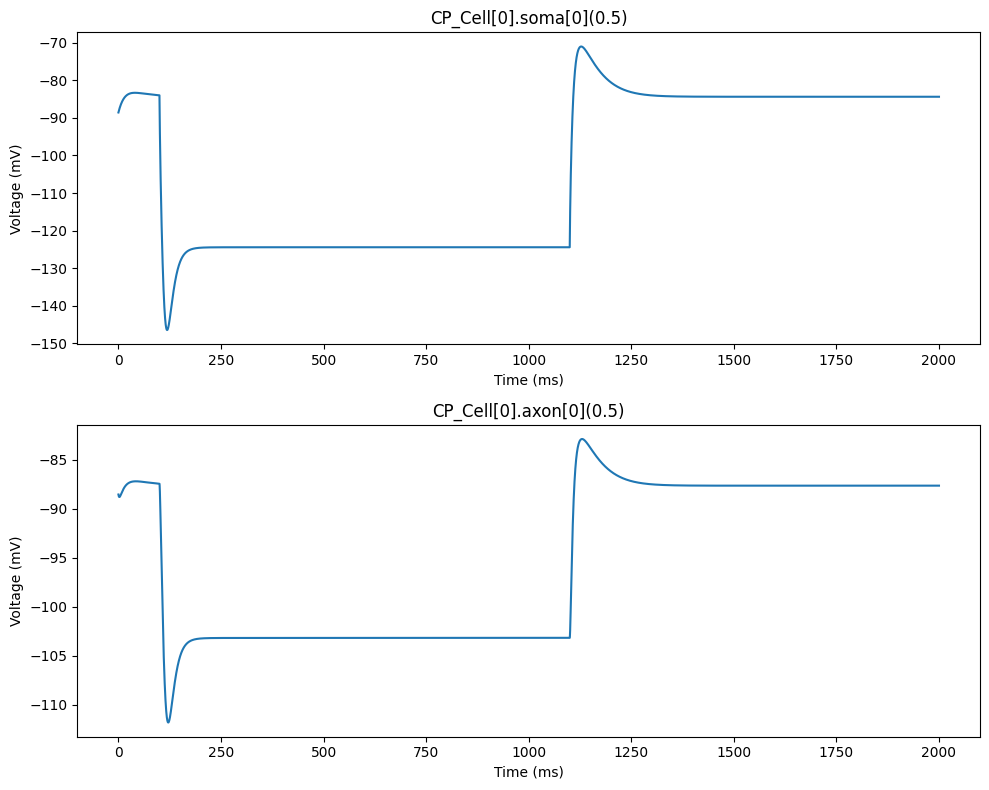

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 8))  # 10 subplots stacked vertically, figure size is 10x20 inches
for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Question
2. The overshoot in the voltage's response to negative current injection is indicative of a higher order system. What causes a multicompartmental model to be a higher order system?(Hint: think in terms of coupling first order differential equations to create higher order ones)

# Calculation of Input Resistance
$$
R_{in} = \frac{V_{rest}-V_{inject}}{I_{inject}}
$$
The input resistance is the change in voltage is just the difference from the resting membrane potential and steady state potential during injection. It is a passive property of the membrane. After finding it, we can just plug it in to find the input resistance.
(Note: voltage is measured in mV, which is 10^-3 V. Current is measured in nA, which is 10^-9 amps. After the division, you're left with 10 ^ 6 Ohms, which is 1 MOhm, which is why that is the unit used). For more information on input resistance, click [here.](https://www.scientifica.uk.com/learning-zone/passive-membrane-properties)

In [14]:
# Find Resting membrane potential
rest_time = (h.tstop + (IC.dur + IC.delay)) / 2 # guarantees to be at a time after current injection is over
# print(rest_time)
rest_time_index = int(rest_time / h.dt)
rest_V_soma = V_vecs[0][rest_time_index]
print(f"rest_V_soma: {round(rest_V_soma,2)} mV")

# Find Steady state membrane potential during injection
inj_SS_time = (IC.dur + IC.delay) / 2
# print(inj_SS_time)
inj_SS_time_index = int(inj_SS_time / h.dt)
inj_SS_V_soma = V_vecs[0][inj_SS_time_index]
print(f"inj_SS_V_soma: {round(inj_SS_V_soma,2)} mV")

# Compute input resistance
V_change = inj_SS_V_soma - rest_V_soma
print(f"V_change: {round(V_change,2)} mV")
print(f"Current Injection Amplitude: {IC.amp} nA")
Input_resistance = V_change / IC.amp
print(f"Input_resistance: {round(Input_resistance,2)} MOhms")


rest_V_soma: -84.35 mV
inj_SS_V_soma: -124.45 mV
V_change: -40.11 mV
Current Injection Amplitude: -1.0 nA
Input_resistance: 40.11 MOhms


# Questions
3.  What is Input Resistance?
4.  Repeat the simulation with a current injection of -2 nA. What do you get as the input resistance? What does this tell you about input resistance in general?
5.  Is a cell with higher input resistance or lower input resistance more likely to fire an action potential when the same current is injected into the soma?
6.  Can the idea of Input Resistance be applied to dendritic compartments?

## F/I Curves

The F/I(Frequency-Current) curve shows the relationship beteween the frequency of spikes(or action potentials) to the amplitude of the current injected. It is sometimes call the FR-IC(Firing Rate-Current) curve as well.

# Simulation Parameters
The length of the simulation and inital voltages are the same as last time. This time we will be running multiple simulations with different levels of current injection(from -1 nA to 2 nA). While recording the voltage throughout these simulations, the amount of spikes created will also be recorded.

In [15]:
# # define simulation parameters
#h.tstop = tstop = 2000 # how long to run the simulation in ms
#h.dt = 0.025 # time step (resolution) of the simulation in ms
#h.v_init = cell.soma[0].e_pas # give v(0) = e_leak

# Perform Simulations with varying current injection amplitude

def set_spike_recorder(cell, spike_threshold, seg_to_record='soma') -> None:
    vec = h.Vector()
    if seg_to_record == 'soma':
      nc = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec = cell.soma[0])
    elif seg_to_record == 'axon':
      nc = h.NetCon(cell.axon[0](0.5)._ref_v, None, sec = cell.axon[0])
    else:
      raise(ValueError(f"{seg_to_record} should be 'soma' or 'axon'"))
    nc.threshold = spike_threshold
    nc.record(vec)
    return vec

V_vecs = [] # list of voltage vectors
segs = []
amps = np.arange(-1.0,2.,.25)
spike_arrays = []

for amp in amps:
  IC.amp = amp # amplitude in nA
  # record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
  i_leak_vecs = []


  spikes = set_spike_recorder(cell=cell, spike_threshold = 0)

  #record soma voltage
  seg = cell.soma[0](0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  #V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  seg_i_leak_vec.record(seg._ref_i_pas)
  i_leak_vecs.append(seg_i_leak_vec)

  t_vec = h.Vector() # time vector
  t_vec.record(h._ref_t) # record time during simulation
  h.run() # run simulation
  V_vecs.append(np.array(seg_V_vec))
  spike_arrays.append(spikes)

# Plotting Voltage
This graphs the voltage within the soma throughout current injection at the different amplitudes.

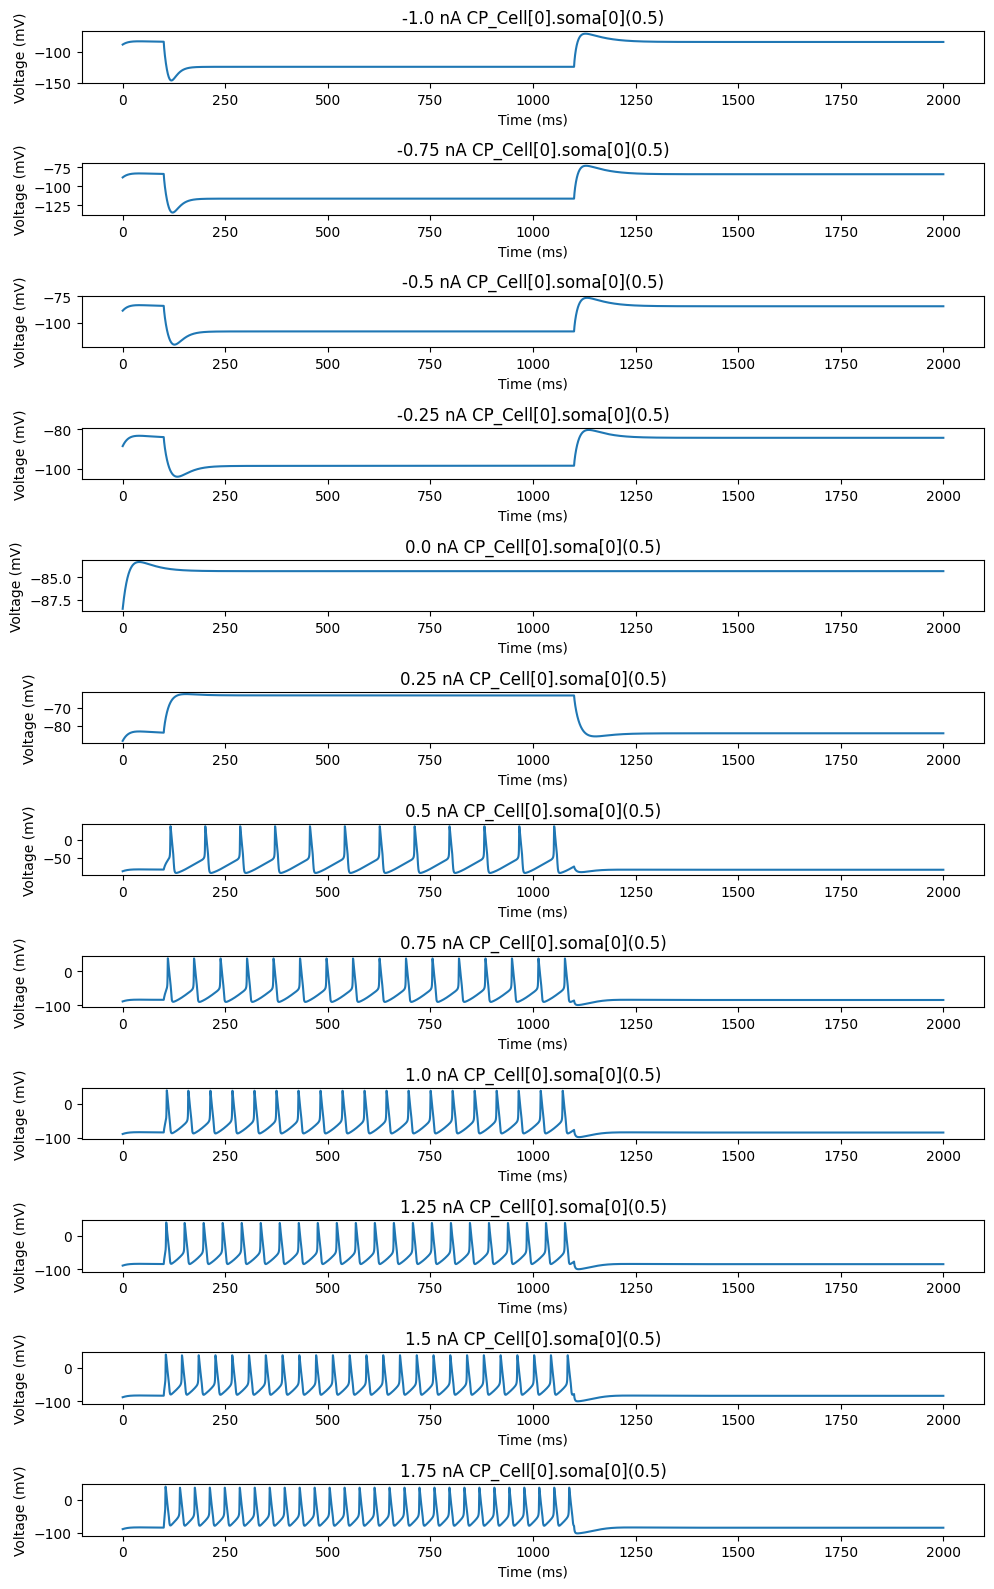

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x16 inches
for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(f"{amps[i]} nA {seg}")
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Firing Rates
Firing Rates are given in Hz(spikes per second). Firing rates are just the frequency in which a cell generates spikes. This will get the firing rates at each amplitude based off of how many spikes were generated during the simulation.

In [17]:
firing_rates = []
for spike_array in spike_arrays:
  #print(len(spike_array))
  num_spikes = len(spike_array)
  #print(len(spike_array))
  firing_rate = num_spikes / (IC.dur / 1000) #duration is in ms, so divide by /1000 to get in seconds
  firing_rates.append(firing_rate)

# Plotting the FI Curve
Now that we have the the frequency and current, we can plot it. Since the frequency is dependent on the current injected, the current will be on the x-axis and the frequency will be on the y-axis.

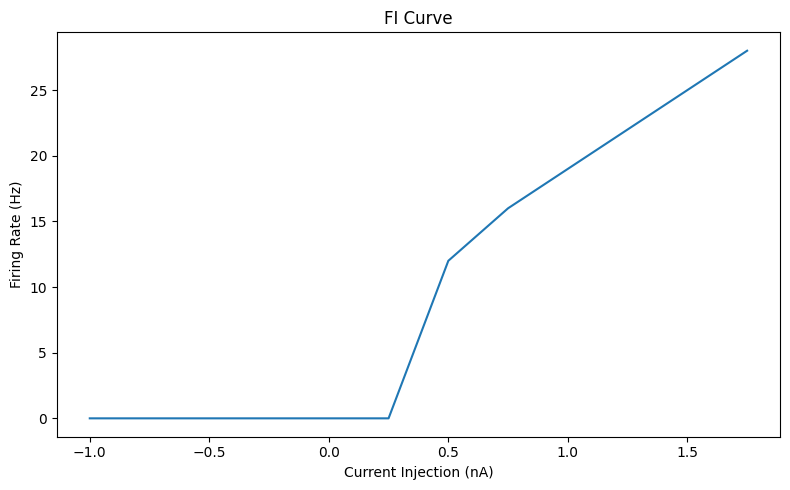

In [18]:
# Plot F/I curve
fig, axs = plt.subplots(1, 1, figsize=(8, 5))  # 10 subplots stacked vertically, figure size is 10x20 inches

axs.plot(amps, firing_rates)
axs.set_title(f"FI Curve")
axs.set_xlabel('Current Injection (nA)')
axs.set_ylabel('Firing Rate (Hz)')
  # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Note
The slope of the FI curve can be described using a piecewise function.

Part of this FI curve is given as a piecewise function below. Can you figure out the rest?

$$
f(I) = \{I ≤ 0.25: \frac{dF}{dI} = 0,0.25 ≤ I ≤ 0.5 :\frac{dF}{dI}=48\}
$$

## Action Potential Propagation
Action Potential Propagation refers how an action potential travels down through the axon. See the two videos below for a more detailed overview. The next simulation will focus on AP propagation with myelin sheaths, although a brief visit without it will be done as well.


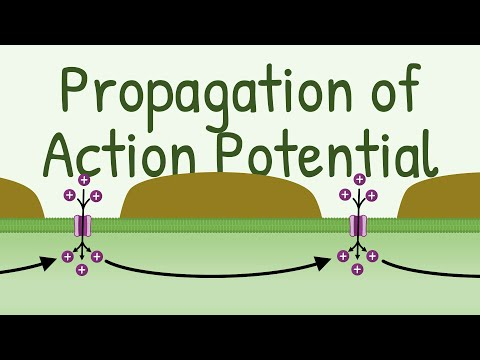

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo('tOTYO5WrXFU')

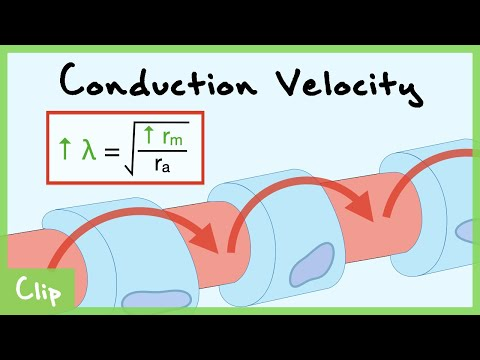

In [20]:
YouTubeVideo('5WNWFyvUA5w')

Explore How Nodes of Ranvier and Myelin Sheath allow the Action Potential to reliably travel down the Axon. Elongate the Axon, adding long myelinated sections sepearted by Nodes of Ranvier. Myelinated sections should have a higher membrane resistance (lower leak conductance), and Nodes should have a higher density of active channels.


# Additions to The Simulation
This simulation will add 5 pairs of myelin sheaths and Nodes of Ranvier to view how spikes propagate throughout. Important things to note are that the myelinated segments have no active channels and a very, very low leak conductance. Myelinated segments are also much longer than the nodes. Lastly, the diameter of these segments is half of the original axon, with a 10th of the original axial resitivity.

In [21]:
# Initial parameters
axon_diam = cell.axon[0].diam * 2 #2  # diameter of the axon
cell.axon[0].Ra = cell.axon[0].Ra / 10


# List to hold all axon sections
nodes = []
myelinated_sections = []
new_sections = []

# Define properties for myelinated segments and Nodes of Ranvier
myelin_length = 225 #1000
node_length = 1
# myelin_resistance = 1000
# node_resistance = 0.01

for i in range(10):
    if i % 2 == 0:  # Myelinated segment
        axon = h.Section(name='Myelinated[{}]'.format(i+1))
    else:
        axon = h.Section(name='Node[{}]'.format(i+1))
    new_sections.append(axon)
    axon.insert('hh')
    #  op0
    axon.cm = cell.axon[0].cm
    for seg in axon:
      seg.hh.el = cell.axon[0](0.5).pas.e
    axon.Ra = cell.axon[0].Ra #/ 3

    # connect to previous section
    if i == 0:
        axon.connect(cell.axon[0](1))
    else:
        axon.connect(new_sections[i-1](1))

    if i % 2 == 0:  # Myelinated segment
        myelinated_sections.append(axon)
        axon.L = myelin_length
        axon.diam = axon_diam
        axon.nseg = 20  # This might vary depending on your requirement
        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10000000  # Maximal conductance of leak channels
            seg.hh.gkbar =0# 0.036/1000#0.036/10  # Maximal conductance of K channels
            seg.hh.gnabar = 0#0.12/1000  # Maximal conductance of Na channels


        # You might also add other properties specific to myelinated segments

    else:  # Node of Ranvier
        nodes.append(axon)
        axon.L = node_length
        axon.diam = axon_diam

        for seg in axon:
            seg.hh.gl = cell.axon[0](0.5).g_pas / 10  # may update to 80 mS / unit area
            seg.hh.gkbar = 0.036 * 1000  # Maximal conductance of K channels
            seg.hh.gnabar = 0.12 * 500   # Maximal conductance of Na channels

        axon.nseg = 1  # Usually a node of ranvier is represented by one segment

    # Print out some properties for verification
    print("Axon section {}: L = {} um, diam = {} um".format(i, axon.L, axon.diam))


Axon section 0: L = 225.0 um, diam = 28.19325637817383 um
Axon section 1: L = 1.0 um, diam = 28.19325637817383 um
Axon section 2: L = 225.0 um, diam = 28.19325637817383 um
Axon section 3: L = 1.0 um, diam = 28.19325637817383 um
Axon section 4: L = 225.0 um, diam = 28.19325637817383 um
Axon section 5: L = 1.0 um, diam = 28.19325637817383 um
Axon section 6: L = 225.0 um, diam = 28.19325637817383 um
Axon section 7: L = 1.0 um, diam = 28.19325637817383 um
Axon section 8: L = 225.0 um, diam = 28.19325637817383 um
Axon section 9: L = 1.0 um, diam = 28.19325637817383 um


# Functions to Change Parameters
These functions will be used to change different parameters such as the diameter, the axial resistance, the active conductance of the nodes, the leak conductance of the myelinated segments, and simulate no myelinated segments to then later answer questions.

In [22]:
#changes something that affects both nodes and myelinated sections
def changeAllSections(change, param_to_change = 'diam') ->None:
  for section in new_sections:
    if(param_to_change == 'diam'):
      section.diam = (cell.axon[0].diam * 2) * change
    elif(param_to_change == 'Ra'):
          section.Ra = cell.axon[0].Ra * change
    else:
      raise(ValueError(f"{param_to_change}should be 'diam' or 'Ra'"))
      break

#changes the k and na conductances of the nodes of ranvier by a constant change
def changeNodeActiveConductance(change):
  for node in nodes:
    for seg in node:
        seg.hh.gkbar = (0.036 * 1000) * change
        seg.hh.gnabar = (0.12 * 500) * change

#changes the myelin leak conductant by a constant change
def changeMyelinLeakConductance(change):
  for myelin in myelinated_sections:
    for seg in myelin:
      seg.hh.gl = (cell.axon[0](0.5).g_pas / 10000000) * change

#sets myelin conductance to wanted value
def setMyelinConductance(value, channel_to_change = 'gl')->None:
  for myelin in myelinated_sections:
    for seg in myelin:
      if(channel_to_change == 'gl'):
        seg.hh.gl = value
      elif(channel_to_change == 'gkbar'):
        seg.hh.gkbar = value
      elif(channel_to_change == 'gnabar'):
        seg.hh.gnabar = value
      else:
        raise(ValueError(f"{channel_to_change}should be 'gl', 'gkbar', or 'gnabar'"))
        break

#sets node conductance to wanted value
def setNodeConductance(value, channel_to_change = 'gl')->None:
  for node in nodes:
    for seg in node:
      if(channel_to_change == 'gl'):
        seg.hh.gl = value
      elif(channel_to_change == 'gkbar'):
        seg.hh.gkbar = value
      elif(channel_to_change == 'gnabar'):
        seg.hh.gnabar = value
      else:
        raise(ValueError(f"{channel_to_change}should be 'gl', 'gkbar', or 'gnabar'"))
        break



#sets everything to initial values
def changeToDefault():
  changeAllSections(1,'diam') #initial val
  changeAllSections(1,'Ra') #initial val
  changeNodeActiveConductance(1) #initial val
  setNodeConductance(cell.axon[0](0.5).g_pas / 10,'gl') #initial val
  changeMyelinLeakConductance(1) #initial val
  setMyelinConductance(0,'gkbar') #initial val
  setMyelinConductance(0,'gnabar') #initial val

def simulateNoMyelin():
  setMyelinConductance(cell.axon[0](0.5).g_pas / 100, 'gl') # similar gl as Node of Ranvier
  setMyelinConductance(0.036/1000,'gkbar') #similar gk as Node of Ranvier
  setMyelinConductance(0.12/1000, 'gnabar') #similar gna as Node of Ranvier



def set_node_spike_recorder(node, spike_threshold,i):
  vec = h.Vector()
  nc = h.NetCon(node(i)._ref_v,None,sec = node)
  nc.threshold = spike_threshold
  nc.record(vec)
  return vec




# Changing Parameters
This is where parameters will be changed to answer questions. changeToDefault just reverts everything back to the initial values and should always be done before anything else. The number put into the change... functions is how how much the value is being multiplied. So if the Node active conductance is 30 and changeNodeActiveConductance(1/10) is called, it will be changed to 30 * 1 / 10, or 3. To run these different functions, simply delete the hashtag and then re run the code block. If you don't want to run it, put the hastag back on.

In [23]:
changeToDefault()
#changeNodeActiveConductance(1/10)
#changeMyelinLeakConductance(10)
#changeAllSections(10,'Ra')
#changeAllSections(0.75,'diam')
#simulateNoMyelin()


# Running the Simulation
The simulation is ran here for the same amount of time as every other simulation. While here, the spikes are recorded from the first and last node. Also, the amp is defined to be 0.6 for these simulations.

In [24]:
# define simulation parameters
#IC.delay = 100.0 # delay in ms
#IC.dur = 1000.0 # duration in ms
IC.amp = 0.6 #nA
#h.tstop = tstop = 2000 # how long to run the simulation in ms
#h.dt = 0.025 # time step (resolution) of the simulation in ms
#h.v_init = cell.soma[0].e_pas # give v(0) = e_leak


# record the voltage (_ref_v) and time (_ref_t) into the vectors we just created
V_vecs = [] # list of voltage vectors
i_leak_vecs = []
segs = []

#record soma
seg = cell.soma[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)
# record leak current
seg_i_leak_vec = h.Vector()
seg_i_leak_vec.record(seg._ref_i_pas)
i_leak_vecs.append(seg_i_leak_vec)

#record main axon
seg = cell.axon[0](0.5)
segs.append(seg)
seg_V_vec = h.Vector() # define vector object for recording variable
seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
V_vecs.append(seg_V_vec)

for sect in new_sections:
  seg = sect(0.5)
  segs.append(seg)
  seg_V_vec = h.Vector() # define vector object for recording variable
  seg_V_vec.record(seg._ref_v) # record simulated voltage into vector
  V_vecs.append(seg_V_vec)
  # record leak current
  seg_i_leak_vec = h.Vector()
  try:seg_i_leak_vec.record(seg._ref_i_pas)
  except:seg_i_leak_vec.record(seg._ref_il_hh)
  i_leak_vecs.append(seg_i_leak_vec)


axon_spikes = set_spike_recorder(cell=cell, spike_threshold = 0, seg_to_record = 'axon')
first_node_spikes = set_node_spike_recorder(nodes[0],0,0)
last_node_spikes = set_node_spike_recorder(nodes[len(nodes)-1], 0,1)


t_vec = h.Vector() # time vector
t_vec.record(h._ref_t) # record time during simulation

# dir(new_sections[0](0.5).hh.il) #gives all information about the section
h.run() # run simulation
V_vecs.append(np.array(seg_V_vec))

# Plotting Voltage/Spikes
The voltage is plotted over the simulation throughout each section of the cell, from the soma to the last node.

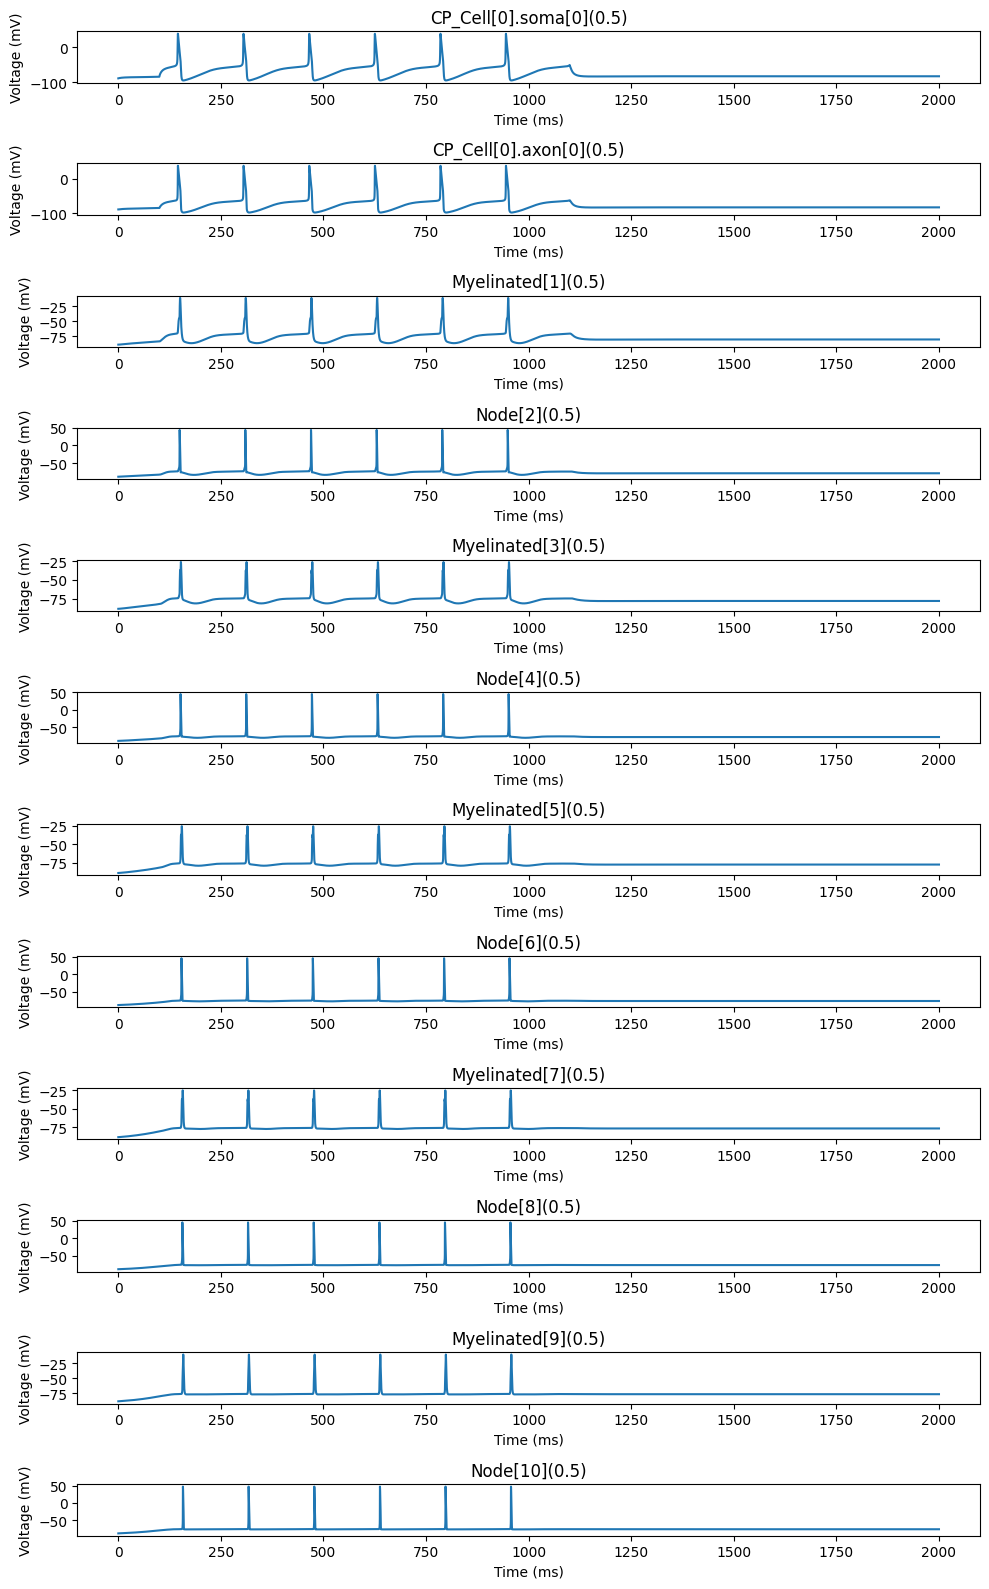

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(segs), 1, figsize=(10, 16))  # 10 subplots stacked vertically, figure size is 10x20 inches

for i,seg in enumerate(segs):  # Assuming you have 10 segments in your axon
    axs[i].plot(t_vec, V_vecs[i])
    axs[i].set_title(str(seg))
    axs[i].set_xlabel('Time (ms)')
    axs[i].set_ylabel('Voltage (mV)')
    # axs[i].set_ylim(-70,vc.amp[0]+1)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()

# Questions
7.   Reduce the Node of Ranvier's active conductances to 10% of the original and rerun the simulation. Explain the importance and role of the Nodes.
8.   Return to the default and then increase the Myelinated sections' leak conductance to be 10 times greater and rerun the simulation. Explain the importance and role of the Myelin sheath.
9.   Return to the default and then increase the axial resistance to be 10 times greater and rerun the simulation. What happens when the axial resistance is higher? Explain how axial resistance affects the propagation of an action potential.
10.   To make it easier for a voltage waveform to propagate along a dendrite, should the axial resistance be higher or lower? What about membrane resistance?


# AP(Action Potential) Propagation Velocity
After recording when the spikes occured in the first and last nodes. The AP propagation velocity can be easily calculated by the followoing formula:
$$
v_{ap} = \frac{d}{Δt}
$$
Where d is the distance from the two nodes, and delta t is the change in time for the spike to get from the axon to the last node. This can be rewritten as:
$$
v_{ap} = \frac{d}{t_{last}-t_{first}}
$$

In [26]:
#print(first_node_spikes[0])
#print(last_node_spikes[0])
#print(first_node_spikes)
time = last_node_spikes[0] - axon_spikes[0]

time_in_secs = time / 1000
length = 0
length = length +((len(myelinated_sections)) * myelin_length) #add all myelinated sections
length = length + (len(nodes) * node_length) #add all nodes
length = length + axon.L #add axon. Length is in microns
ap_velocity = length / time_in_secs

print("AP velocity is " + str(round(ap_velocity)) +  " microns/s")

AP velocity is 91210 microns/s


# Questions
11. Return to the default and then change the diameter to be 75% of the original and rerun the simulation. What happens to the axon propagation speed? Why does this occur? (Hint: Watch the second video)
12. Simulate what happens when there is no myelination. What happens to the axon propagation speed? Why does this occur? (Hint: watch the second video)